# Übung: Klassifikation mit Random Forest & XGBoost

**Ziel dieser Übung:**
Vergleichen Sie Random Forest und XGBoost anhand des Breast Cancer Wisconsin (Diagnostic) Datasets. Sie implementieren die Modelle, experimentieren mit Schlüsselparametern und vergleichen die Ergebnisse.

**Dauer:** ca. 45 Minuten

**Voraussetzungen:** Python, scikit-learn, pandas, matplotlib, xgboost


## 1. Daten laden und explorative Analyse

In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### Aufgabe 1
- Führen Sie folgende Befehle aus und interpretieren Sie die Ergebnisse:
  - `df.info()`
  - `df.describe()`
  - `df['target'].value_counts()`
- Beantworten Sie:
  - Wie viele Beispiele enthält jede Klasse?
  - Welche Features weisen Auffälligkeiten in Skala oder Verteilung auf?
  - Warum könnte eine Standardisierung später sinnvoll sein?

In [2]:
### Lösung
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = df[data.feature_names]
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=data.feature_names)



 ### Lösung Aufgabe 1:
 - 569 Instanzen, 30 numerische Features + Zielspalte.
- Zielverteilung: 212 maligne (0), 357 benigne (1).
- Einige Features (z.B. mean area) haben größere Wertebereiche; Standardisierung erforderlich.


## 2. Datenvorbereitung und Split

In [3]:
X = df_scaled
y = df['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

### Aufgabe 2:
- Überprüfen Sie die Klassenverteilung in `y_train` und `y_test`.

In [4]:
# Klassenverteilung prüfen
print("Train klassenzählung:\n", y_train.value_counts())
print("Test klassenzählung:\n", y_test.value_counts())

Train klassenzählung:
 target
1    250
0    148
Name: count, dtype: int64
Test klassenzählung:
 target
1    107
0     64
Name: count, dtype: int64


## 3. Random Forest Klassifikation

### 3.1: Erstes Modelltraining und Evaluation

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
probs = rf.predict_proba(X_test)[:, 1]

### Aufgabe 3:
- Berechnen und protokollieren Sie:
  - Accuracy (`accuracy_score(y_test, y_pred)`)
  - Precision (gewichtet) (`precision_score(y_test, y_pred, average='weighted')`)
  - Recall (gewichtet) (`recall_score(y_test, y_pred, average='weighted')`)
  - ROC-AUC (`roc_auc_score(y_test, probs)`)
- Diskutieren Sie: Welche Metrik ist in diesem medizinischen Klassifikationskontext besonders relevant?


In [6]:
### Lösung
acc_rf = accuracy_score(y_test, y_pred)
prec_rf = precision_score(y_test, y_pred, average='weighted')
rec_rf = recall_score(y_test, y_pred, average='weighted')
auc_rf = roc_auc_score(y_test, probs)

print(f"RF Accuracy: {acc_rf:.3f}")
print(f"RF Precision (gewichtet): {prec_rf:.3f}")
print(f"RF Recall (gewichtet): {rec_rf:.3f}")
print(f"RF ROC-AUC: {auc_rf:.3f}")

RF Accuracy: 0.936
RF Precision (gewichtet): 0.936
RF Recall (gewichtet): 0.936
RF ROC-AUC: 0.991


### Lösung Aufgabe 3:
- In medizinischem Kontext sind Recall (Sensitivität) und ROC-AUC besonders wichtig, um falsch negative zu minimieren.

### 3.2 Hyperparameter-Experiment


In [7]:
results = []
n_estimators = [50, 100, 200]
max_depth = [3, 8, 32]
for n in n_estimators:
    for d in max_depth:
        model = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
        model.fit(X_train, y_train)
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        results.append({'n_estimators': n, 'max_depth': d, 'roc_auc': auc})

### Aufgabe 4:
- Wandeln Sie `results` in einen DataFrame um und visualisieren Sie die ROC-AUC-Werte als Heatmap oder Linienplot.
- Erläutern Sie den Einfluss von `max_depth` auf Overfitting/Underfitting.

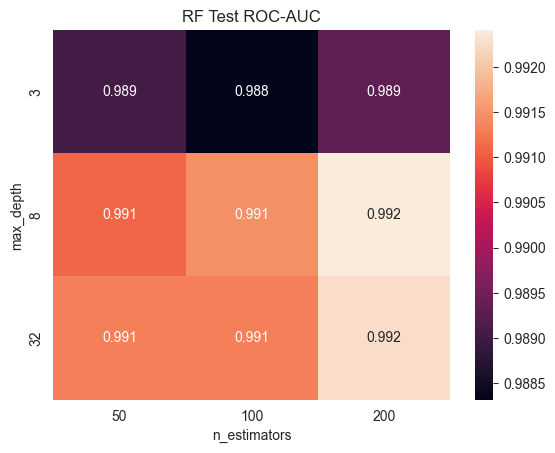

In [8]:
### Lösung
df_rf = pd.DataFrame(results)
df_rf_pivot = df_rf.pivot(index='max_depth', columns='n_estimators', values='roc_auc')
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(df_rf_pivot, annot=True, fmt='.3f')
plt.title('RF Test ROC-AUC')
plt.show()

### Lösung Aufgabe 4:
- Tiefere Bäume (max_depth=8) reduzieren Overfitting
- Mehr Bäume verbessern leicht die Stabilität.

## 4. XGBoost Klassifikation

### 4.1 Erstes XGBoost-Modell

In [9]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
probs_xgb = xgb.predict_proba(X_test)[:, 1]

### Aufgabe 5:
- Berechnen Sie dieselben Metriken wie bei Random Forest und vergleichen Sie die Ergebnisse.


In [10]:
# Lösung
acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
rec_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
auc_xgb = roc_auc_score(y_test, probs_xgb)

print(f"XGB Accuracy: {acc_xgb:.3f}")
print(f"XGB Precision: {prec_xgb:.3f}")
print(f"XGB Recall: {rec_xgb:.3f}")
print(f"XGB ROC-AUC: {auc_xgb:.3f}")


XGB Accuracy: 0.953
XGB Precision: 0.953
XGB Recall: 0.953
XGB ROC-AUC: 0.996


### 4.2 Hyperparameter-Experiment für XGBoost


In [11]:
results_xgb = []
learning_rates = [0.0001,0.01, 0.1, 0.2]
n_estimators = [50, 100, 200]
for lr in learning_rates:
    for n in n_estimators:
        model = XGBClassifier(
            n_estimators=n,
            learning_rate=lr,
            random_state=42,
            eval_metric='logloss'
        )
        model.fit(X_train, y_train)
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        results_xgb.append({'n_estimators': n, 'learning_rate': lr, 'roc_auc': auc})

### Aufgabe 6:
- Transformieren Sie `results_xgb` zu einem DataFrame und visualisieren Sie die Abhängigkeit der ROC-AUC von `n_estimators` und `learning_rate`.


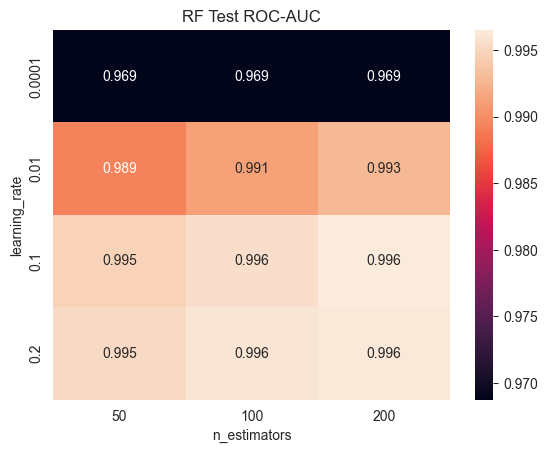

In [12]:
# Lösung
df_xgb = pd.DataFrame(results_xgb)
df_xgb_pivot = df_xgb.pivot(index='learning_rate', columns='n_estimators', values='roc_auc')
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(df_xgb_pivot, annot=True, fmt='.3f')
plt.title('RF Test ROC-AUC')
plt.show()

## 5. Modellvergleich und Visualisierung
### 5.1: ROC-Kurven im Vergleich



In [13]:
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, _ = roc_curve(y_test, probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, probs_xgb)

### Aufgabe 7:
- Plotten Sie beide ROC-Kurven in einem Diagramm.
- Kommentieren Sie: Welches Modell erreicht eine höhere AUC? In welchem Bereich unterscheiden sie sich?

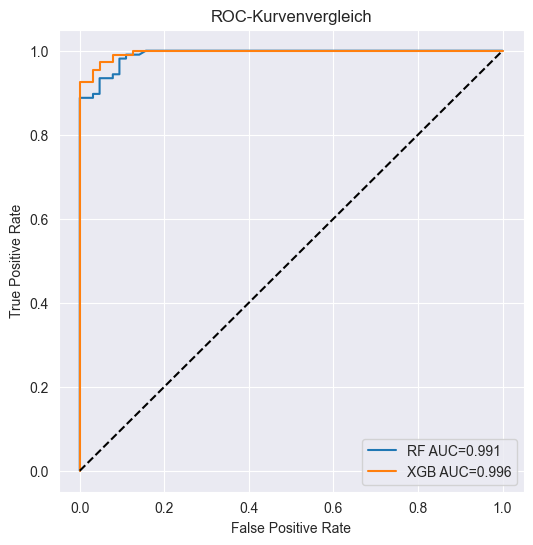

In [14]:
### Lösung
plt.figure(figsize=(6,6))
plt.plot(fpr_rf, tpr_rf, label=f'RF AUC={auc_rf:.3f}')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB AUC={auc_xgb:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurvenvergleich')
plt.legend()
plt.show()

### 5.2: Feature Importance vergleichen


In [15]:
fi_rf = pd.Series(rf.feature_importances_, index=data.feature_names).nlargest(10)
fi_xgb = pd.Series(xgb.feature_importances_, index=data.feature_names).nlargest(10)

### Aufgabe 8:
- Visualisieren Sie die Feature Importances beider Modelle nebeneinander als Balkendiagramme.
- Diskutieren Sie, welche Merkmale für die Klassifikation am relevantesten sind.


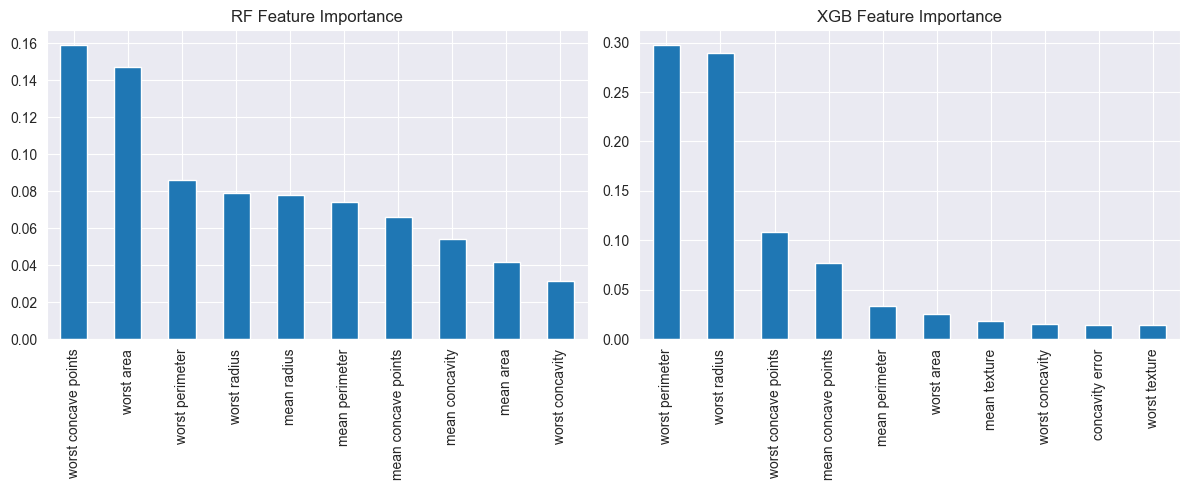

In [16]:
# Lösung
fig, axes = plt.subplots(1,2, figsize=(12,5))
fi_rf.plot.bar(ax=axes[0], title='RF Feature Importance')
fi_xgb.plot.bar(ax=axes[1], title='XGB Feature Importance')
fig.tight_layout()
plt.show()

### Lösung Aufgabe 8:
- Wichtige Merkmale: worst perimeter, mean concavity, worst concavity.
- Beide Modelle gewichten ähnliche Features hoch.
